In [54]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
from scipy.stats import qmc
import tensorflow as tf
import keras
from keras import layers


import explainabilityModels

In [225]:
power_dist = np.random.power(3., size=(128, 2))
power_dist = np.floor(64*power_dist).astype('uint8')
power_dist


In [226]:
def generate_pseudo_img(n_pts = 128, size = 64):
    img = np.zeros([size,size])
    for i in range(n_pts):
        pt = np.random.randint(0, size, size =  (2,1))
        while img[pt[0], pt[1]] == 1:
            pt = np.random.randint(0, size, size =  (2,1))
        img[pt[0], pt[1]] = 1
    return img

def generate_quasi_img(n_exp = 7, size = 64, n_pts = 128):
    sobol = qmc.Sobol(d = 2)
    sample = sobol.random_base2(m=7)
    sample = np.floor(size*sample).astype('uint8')
    qmc_img = np.zeros([size,size])
    for i in range(n_pts):
        qmc_img[sample[i][0], sample[i][1]] = 1
    return qmc_img

def generate_2d_power(n_pts = 128, size = 64, pow = 3):
    power_dist = np.random.power(pow, size=(n_pts, 2))
    power_dist = np.floor(size*power_dist).astype('uint8')
    pow_img = np.zeros([size,size])
    for i in range(n_pts):
        pow_img[power_dist[i][0], power_dist[i][1]] = 1
    return pow_img




In [227]:
#hyperparameters and blank image and label generation
N = 6000
n_exp = 7
n_pts = 2**7
size = 64
labels = np.random.randint(3, size = N)
imgs = np.zeros((size, size, N))


In [231]:
#fill array with corresponding images
from tqdm import tqdm
for i in tqdm(range(N)):
    if labels[i] == 0:
        x = generate_quasi_img(n_exp=n_exp, size=size, n_pts=n_pts)
    elif labels[i] == 1:
        x = generate_pseudo_img(n_pts=128, size=size)
    elif labels[i] == 2:
        x = generate_2d_power(n_pts=128, size=size, pow = 1.5)
    imgs[:,:,i] = x

100%|██████████| 6000/6000 [00:04<00:00, 1249.15it/s]


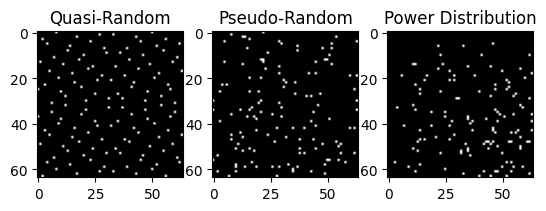

In [242]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,3)

quasi_img = imgs[:,:,np.where(labels == 0)[0][0]]
pseudo_img = imgs[:,:,np.where(labels ==1)[0][0]]
pow_img = imgs[:,:,np.where(labels ==2)[0][0]]

ax[0].imshow(quasi_img, cmap=plt.cm.gray)
ax[1].imshow(pseudo_img, cmap=plt.cm.gray)
ax[2].imshow(pow_img, cmap='gray')

ax[0].set_title("Quasi-Random");
ax[1].set_title("Pseudo-Random");
ax[2].set_title("Power Distribution");


In [233]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(6000, 64, 64, 1)

In [237]:
# Model hyperparameters
num_classes = 3
input_shape = (size, size, 1)
batch_size = 64
epochs = 20
conv_size=(3,3)
save = True
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [238]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # layers.Conv2D(128, kernel_size=conv_size, activation="relu", padding='same'),
        # layers.BatchNormalization(),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.8),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                      

In [239]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/20
57/57 [==============================] - 1s 15ms/step - loss: 1.0311 - accuracy: 0.7993 - val_loss: 3.0488 - val_accuracy: 0.3557
Epoch 2/20
57/57 [==============================] - 1s 12ms/step - loss: 0.1314 - accuracy: 0.9660 - val_loss: 7.2372 - val_accuracy: 0.3557
Epoch 3/20
57/57 [==============================] - 1s 11ms/step - loss: 0.0799 - accuracy: 0.9804 - val_loss: 10.2700 - val_accuracy: 0.3557
Epoch 4/20
57/57 [==============================] - 1s 11ms/step - loss: 0.0913 - accuracy: 0.9820 - val_loss: 12.0583 - val_accuracy: 0.3557
Epoch 5/20
57/57 [==============================] - 1s 11ms/step - loss: 0.0531 - accuracy: 0.9881 - val_loss: 11.6999 - val_accuracy: 0.3557
Epoch 6/20
57/57 [==============================] - 1s 11ms/step - loss: 0.0481 - accuracy: 0.9912 - val_loss: 9.4501 - val_accuracy: 0.3557
Epoch 7/20
57/57 [==============================] - 1s 11ms/step - loss: 0.0354 - accuracy: 0.9934 - val_loss: 7.4268 - val_accuracy: 0.3607
Epoch 8/20

In [35]:
if save:
    model.save("models/model10_distro")

INFO:tensorflow:Assets written to: models/model10_distro/assets


INFO:tensorflow:Assets written to: models/model10_distro/assets


In [10]:
model = tf.keras.models.load_model("models/model10_distro")

In [243]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Quasi-Random', 'Pseudo-Random', 'Power Distribution']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.12314511090517044
Test accuracy: 0.9813131093978882
62/62 [==============================] - 0s 2ms/step
                    precision    recall  f1-score   support

      Quasi-Random       1.00      0.95      0.98       634
     Pseudo-Random       0.95      1.00      0.97       673
Power Distribution       1.00      0.99      0.99       673

          accuracy                           0.98      1980
         macro avg       0.98      0.98      0.98      1980
      weighted avg       0.98      0.98      0.98      1980



In [244]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('Quasi-Random', 0), ('Pseudo-Random', 1), ('Power Distribution', 2)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Quasi-Random', 0), ('Pseudo-Random', 1), ('Power Distribution', 2)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


62/62 [==============================] - 0s 4ms/step


Dropdown(description='True Label:', options=(('Quasi-Random', 0), ('Pseudo-Random', 1), ('Power Distribution',…

Dropdown(description='Predicted Label:', options=(('Quasi-Random', 0), ('Pseudo-Random', 1), ('Power Distribut…

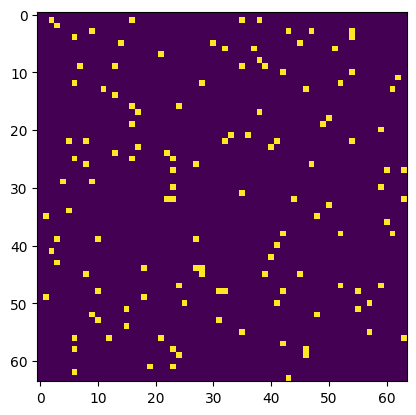

In [258]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][1]]
plt.imshow(img)

In [259]:
heatmap = explainabilityModels.make_gradcam_heatmap(img, model)

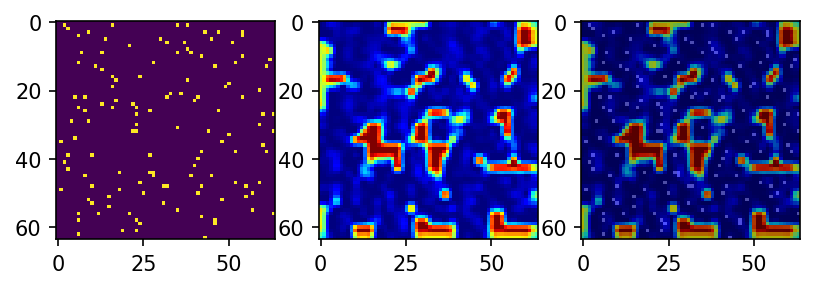

In [260]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(150)
fig.tight_layout

ax[0].imshow(img)
ax[1].imshow(heatmap, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray')
ax[2].imshow(heatmap, alpha = 0.7, cmap='jet')


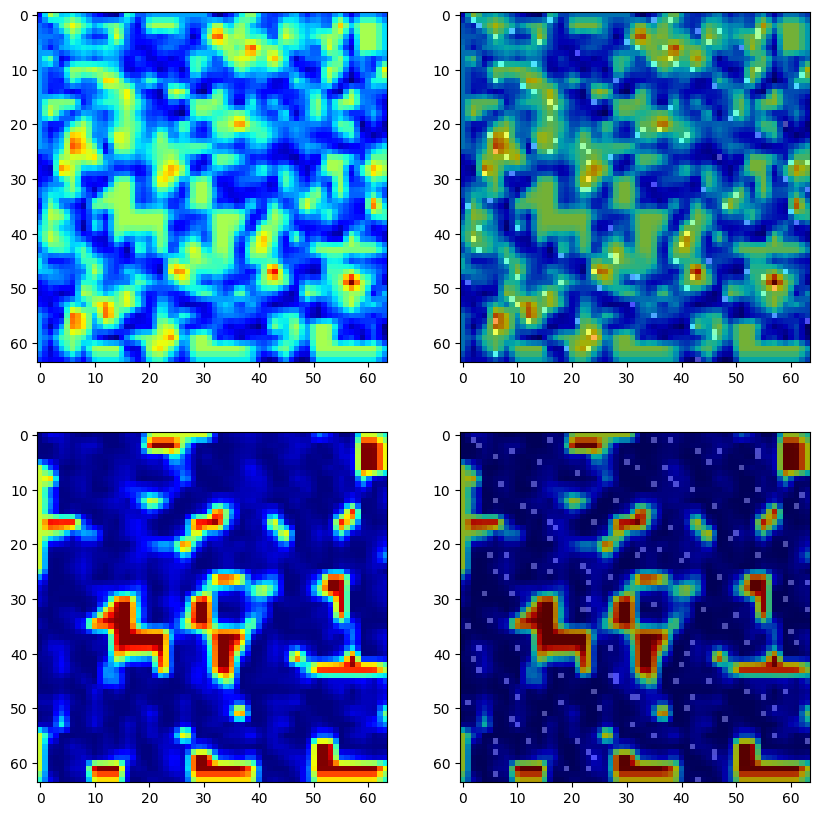

In [261]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), 
            clone=True)
gradcam2 = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(CategoricalScore(1), img).squeeze()
cam2 = gradcam2(CategoricalScore(1), img).squeeze()

fig, ax = plt.subplots(2,2)
fig.set_size_inches((10,10))
ax[0][0].imshow(cam, cmap = 'jet')
ax[0][1].imshow(img, cmap = 'gray')
ax[0][1].imshow(cam, cmap = 'jet', alpha = 0.7)

ax[1][0].imshow(cam2, cmap = 'jet')
ax[1][1].imshow(img, cmap = 'gray')
ax[1][1].imshow(cam2, cmap = 'jet', alpha = 0.7)


2/2 [==============================] - 0s 17ms/step


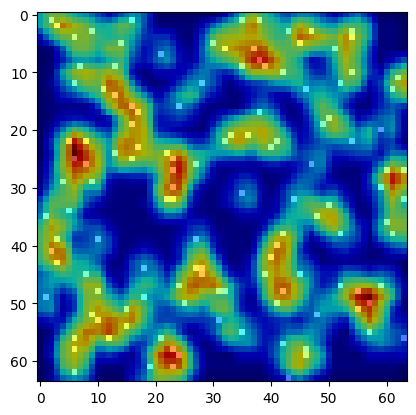

In [262]:
from tf_keras_vis.scorecam import Scorecam

scoreCam = Scorecam(model)

sC = scoreCam(CategoricalScore(1), img).squeeze()

plt.imshow(img, cmap = 'gray')
plt.imshow(sC, cmap = 'jet', alpha = 0.7)